In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from itertools import combinations

In [2]:
cdf = pd.read_csv("gpt-4o-mini_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen", "score"], axis=1)
mdf = pd.read_csv("mistral-small_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen", "score"], axis=1)
cdf_error = pd.read_csv("gpt-4o-mini_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen"], axis=1)
mdf_error = pd.read_csv("mistral-small_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen"], axis=1)

cdf['model'] = 'gpt'
mdf['model'] = 'mistral'

cdf_error['model'] = 'gpt'
mdf_error['model'] = 'mistral'

df_all= pd.concat([cdf, mdf], ignore_index=False)
df_all_error = pd.concat([cdf_error, mdf_error], ignore_index=False)

### RAW GRADES NORMALITY CHECK

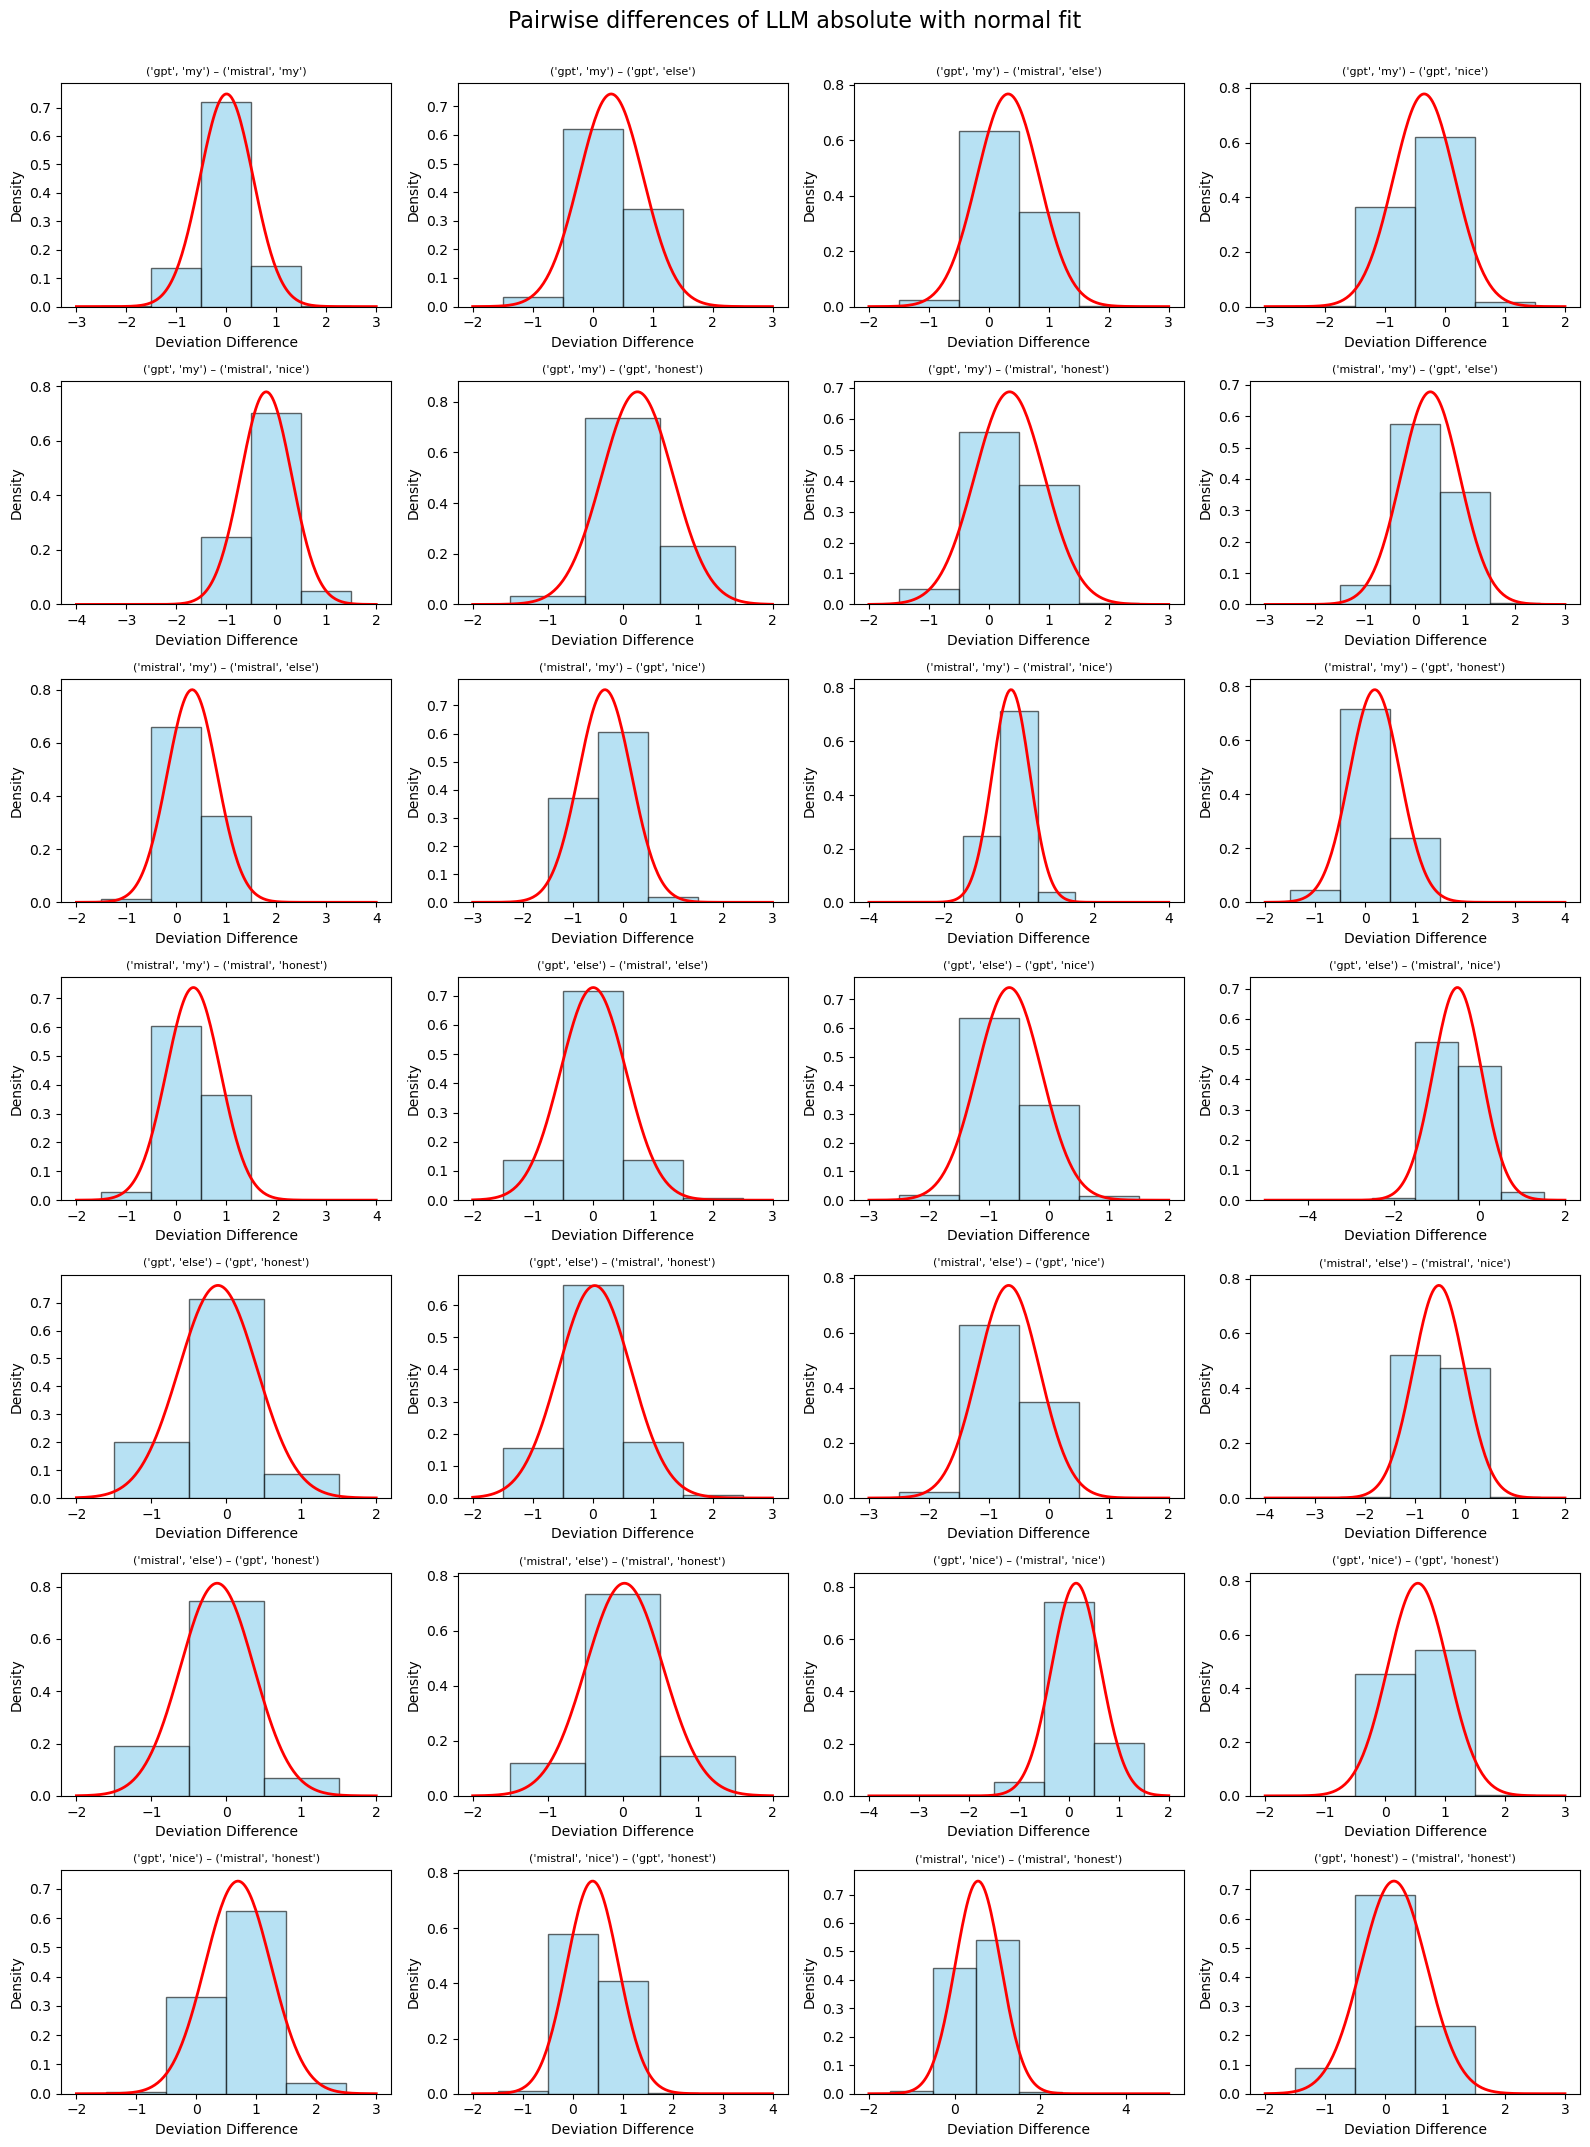

In [3]:
df_long = df_all.melt(id_vars=["i",'model'], 
                            value_vars=['my', 'else', 'nice', 'honest'],
                            var_name='prompt', 
                            value_name='llm_score')

df_wide = df_long.pivot(index='i', columns=['model', 'prompt'], values='llm_score')
conditions = df_wide.columns.tolist()
n = len(conditions)
n_cols = 4
n_rows = int(np.ceil(n * (n - 1) / 2 / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for idx, (cond1, cond2) in enumerate(combinations(conditions, 2)):
    diff = df_wide[cond1] - df_wide[cond2]
    diff = diff.dropna()

    mu, std = diff.mean(), diff.std()
    x = np.linspace(diff.min() - 1, diff.max() + 1, 200)
    y = norm.pdf(x, mu, std)

    ax = axes[idx]
    ax.hist(diff, bins=np.arange(diff.min() - 0.5, diff.max() + 1.5, 1),
            density=True, alpha=0.6, color='skyblue', edgecolor='black')
    ax.plot(x, y, color='red', linewidth=2)
    ax.set_title(f"{cond1} – {cond2}", fontsize=8)
    ax.set_xlabel("Deviation Difference")
    ax.set_ylabel("Density")

for ax in axes[len(list(combinations(conditions, 2))):]:
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Pairwise differences of LLM absolute with normal fit", fontsize=16, y=1.02)
plt.savefig("normality.pdf", format="pdf")
plt.show()


### ERROR NORMALITY CHECK

In [4]:
df_long_error = df_all_error.melt(id_vars=['i', 'model', 'score'], 
                      value_vars=['my', 'else', 'nice', 'honest'], 
                      var_name='prompt', value_name='llm_score')
df_long_error['abs_dev'] = abs(df_long_error['llm_score'] - df_long_error['score'])

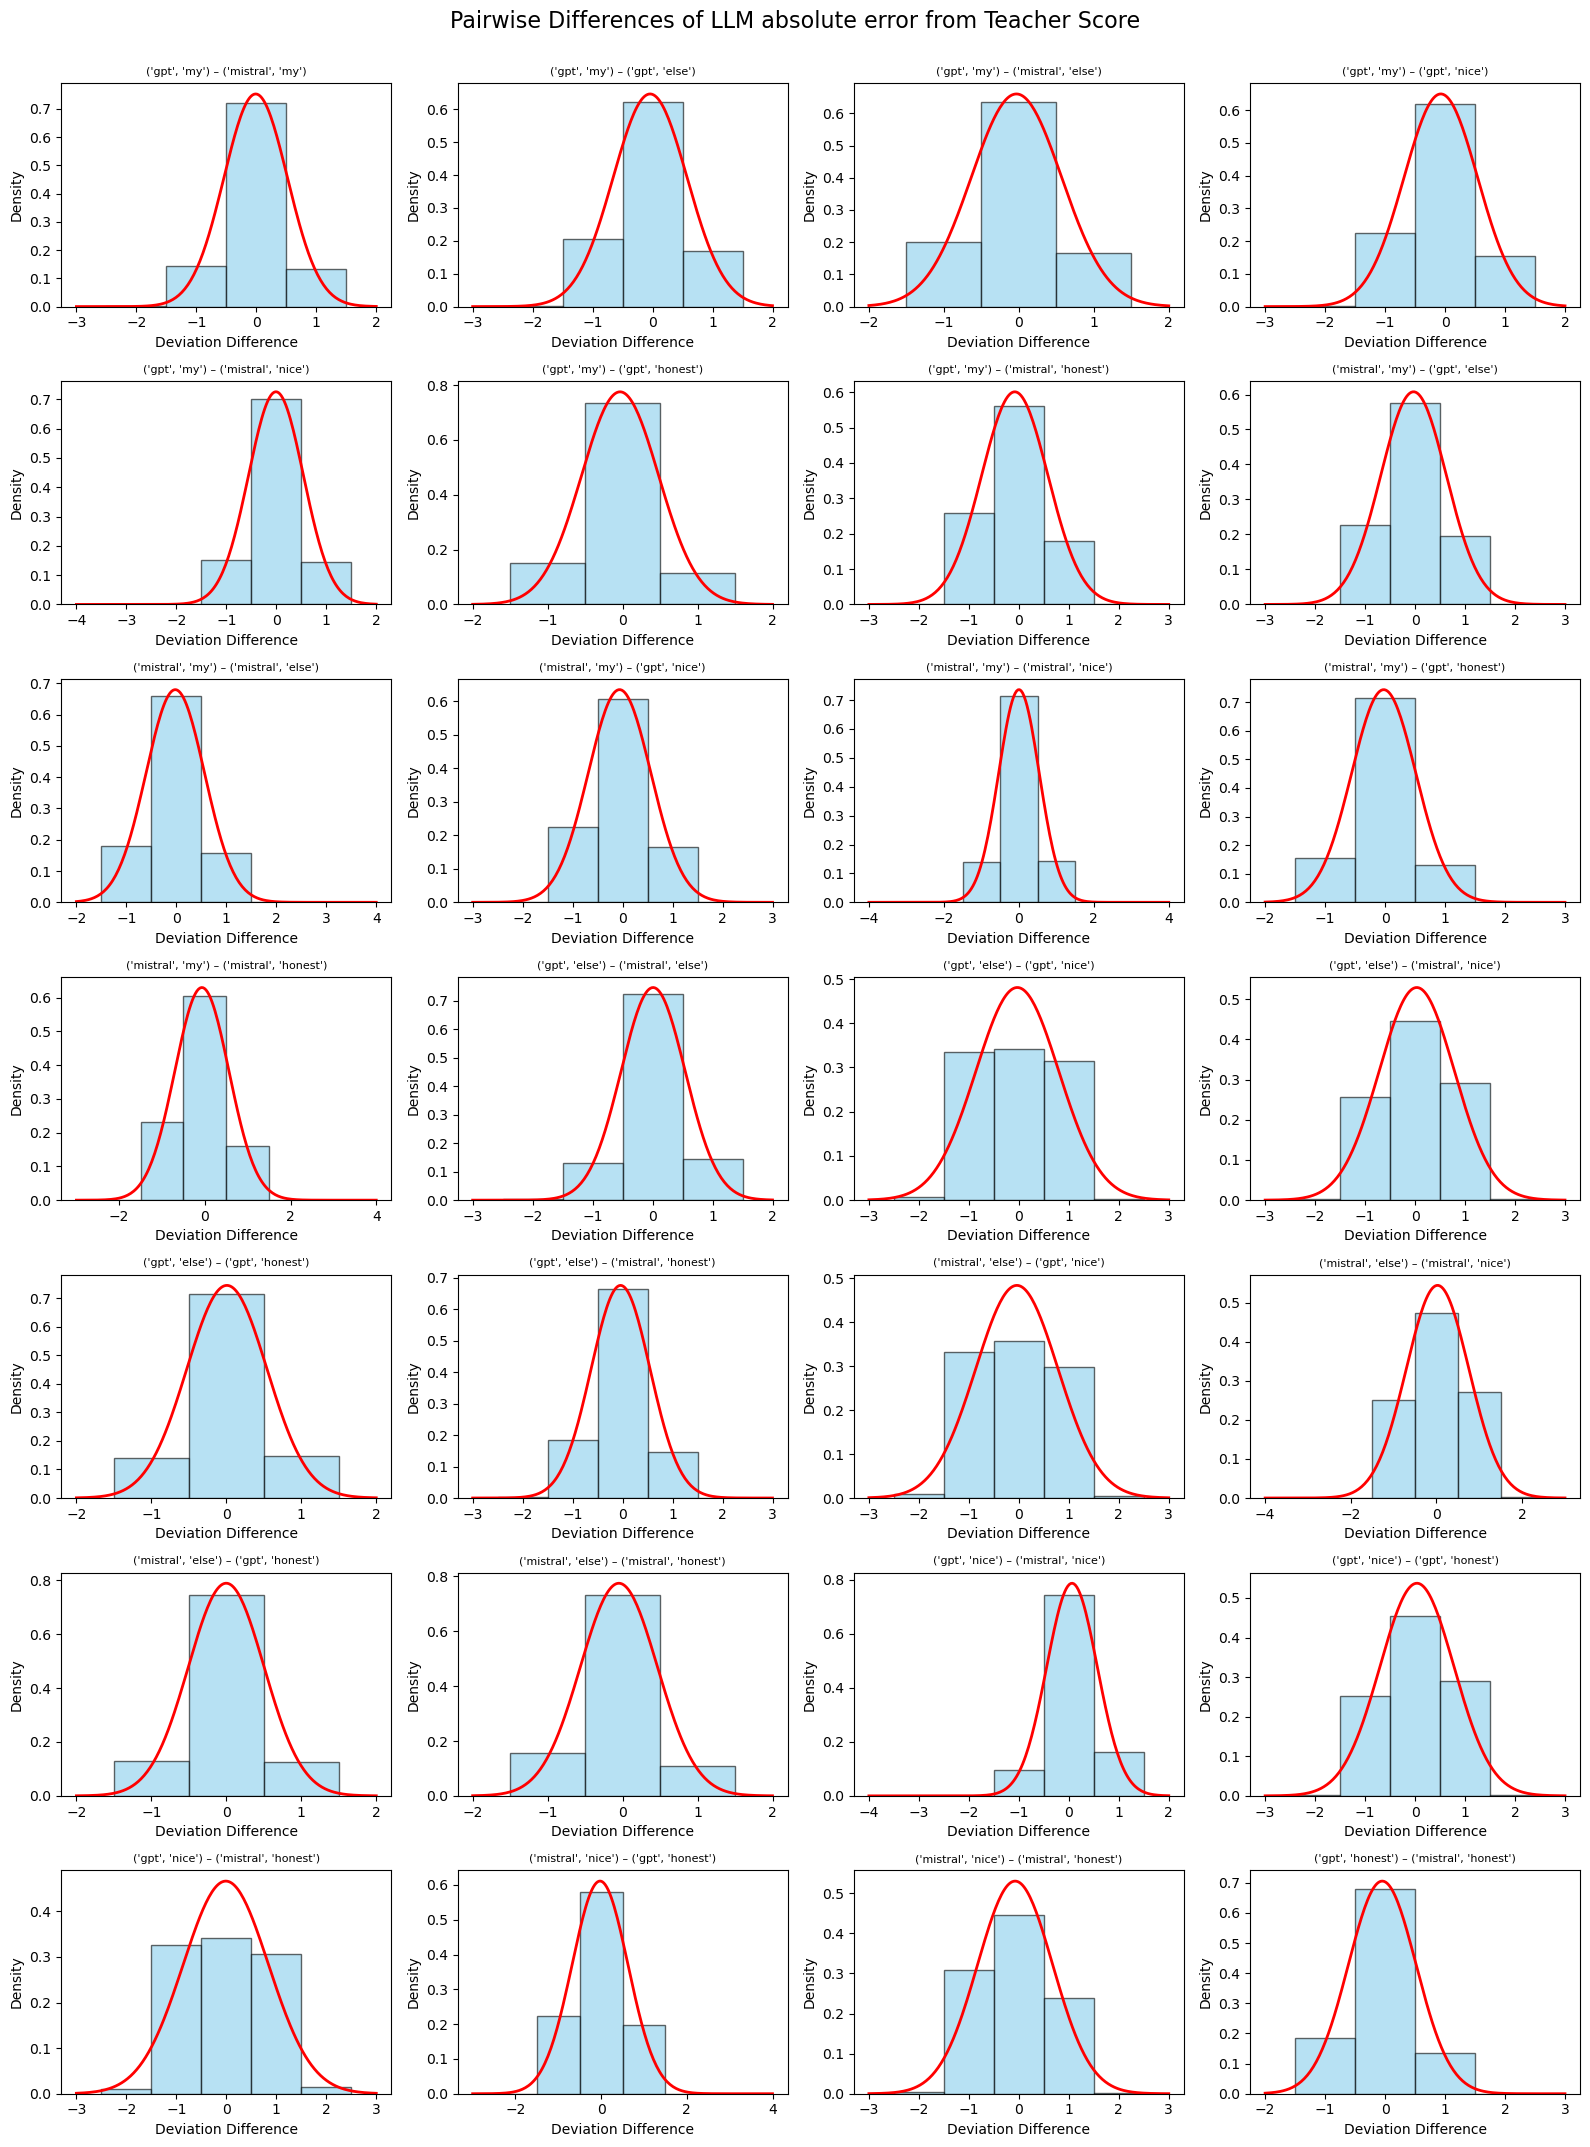

In [5]:
df_dev_wide = df_long_error.pivot(index='i', columns=['model', 'prompt'], values='abs_dev')
conditions = df_dev_wide.columns.tolist()
n = len(conditions)
n_cols = 4
n_rows = int(np.ceil(n * (n - 1) / 2 / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for idx, (cond1, cond2) in enumerate(combinations(conditions, 2)):
    diff = df_dev_wide[cond1] - df_dev_wide[cond2]
    diff = diff.dropna()

    mu, std = diff.mean(), diff.std()
    x = np.linspace(diff.min() - 1, diff.max() + 1, 200)
    y = norm.pdf(x, mu, std)

    ax = axes[idx]
    ax.hist(diff, bins=np.arange(diff.min() - 0.5, diff.max() + 1.5, 1),
            density=True, alpha=0.6, color='skyblue', edgecolor='black')
    ax.plot(x, y, color='red', linewidth=2)
    ax.set_title(f"{cond1} – {cond2}", fontsize=8)
    ax.set_xlabel("Deviation Difference")
    ax.set_ylabel("Density")

# Remove unused subplots
for ax in axes[len(list(combinations(conditions, 2))):]:
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Pairwise Differences of LLM absolute error from Teacher Score", fontsize=16, y=1.02)
plt.savefig("Deviation normality.pdf", format="pdf")
plt.show()
